<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/Termin3_WS2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrixfaktorisierung

In [48]:
from scipy import sparse as sp
import pandas as pd
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

In [49]:
TOP_MOVIES = 100
RANDOM_VIEWERS = 1000
reduced = np.load('netflix_reduced.npy')
headers = []
with open('netflix_headers.txt','r') as fi:
    for line in fi.readlines():
        headers.append(line.strip().split(',')[2])

In [50]:
DATASET = 1
VERBOSE = False #False
ITERATIONS = 100
def setup():
    global R,W,P,Q,ri,ci,k,m,n
    if DATASET == 0:
        R = [[5,4,0],
             [5,5,1],
             [1,0,5],
             [1,1,4]]
        R = np.array(R,dtype=np.float64)
        k=1
    elif DATASET == 1:
        R = reduced
        k = 10
    else:
        assert(False)

    W = R > 0
    m,n = R.shape
    R = (R-3)/2
    vecr = R[W]
    np.random.seed(42)
    P = np.random.rand(m,k)
    Q = np.random.rand(n,k)
def log(text):
    if VERBOSE:
        print(text)

# Einleitung

Sei $m$ die Anzahl der User und $n$ die Anzahl der Filme. Die Bewertungen der User für die Filme ist in zwei Matrizen $W$ und $R$ kodiert. $W \in \{0,1\}^{m \times n}$ ist eine Binärmaske, welche den Eintrag $1$ in einer Zeile $i$ und Spalte $j$ besitzt, falls der User mit dem Index $i$ eine Bewertung für den Film mit dem Index $j$ abgegeben hat. Der Eintrag ist $0$, falls dieser User diesen Film nicht bewertet hat. Sei $z$ die Anzahl der Einsen von $W$. 
Die Bewertungsmatrix $R \in [-1,1]^{m \times n}$ selbst beinhaltet die Bewertung des Films in Form einen Scores. Das Interval $[-1,1]$ wird als $[\text{gefällt nicht},\text{gefällt}]$ interpretiert. 

Existierende Filmbewertungen können Sie mit der plt.spy Funktion einsehen.

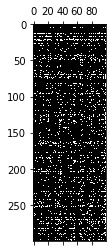

In [51]:
setup()
plt.spy(W)

Eine Auswahl an Filmen finden Sie hier:

In [52]:
headers

['Miss Congeniality',
 'Independence Day',
 'The Patriot',
 'The Day After Tomorrow',
 'Pirates of the Caribbean: The Curse of the Black Pearl',
 'Pretty Woman',
 'Forrest Gump',
 'The Green Mile',
 'Con Air',
 'Twister',
 'Sweet Home Alabama',
 'Pearl Harbor',
 'Armageddon',
 'The Rock',
 'What Women Want',
 'Bruce Almighty',
 "Ocean's Eleven",
 'The Bourne Identity',
 'The Italian Job',
 'I',
 'American Beauty',
 'How to Lose a Guy in 10 Days',
 'Lethal Weapon 4',
 'Shrek 2',
 'Lost in Translation',
 'Top Gun',
 'Pulp Fiction',
 'Gone in 60 Seconds',
 'The Sixth Sense',
 'Lord of the Rings: The Two Towers',
 'Men of Honor',
 'Gladiator',
 'Lord of the Rings: The Fellowship of the Ring',
 'Sister Act',
 'Double Jeopardy',
 'Two Weeks Notice',
 'The Royal Tenenbaums',
 'Troy',
 'National Treasure',
 '50 First Dates',
 'Indiana Jones and the Last Crusade',
 'My Big Fat Greek Wedding',
 'Mystic River',
 'Titanic',
 'Dirty Dancing',
 'Catch Me If You Can',
 'Finding Nemo (Widescreen)',
 '

Ziel der heutigen Aufgabe ist die Prädiktion der fehlenden Einträge in der Bewertungsmatrix $M$. Diese Prädiktionen könnten in einem Recommender-System genutzt werden, um einem User einer Platform einen Film vorzuschlagen.

Eine Möglichkeit bietet die Matrixfaktorisierung. Dabei wird versucht, zwei schlanke Faktoren $P \in \mathbb{R}^{m \times r}$ und $Q \in \mathbb{R}^{n \times k}$ zu finden mit $k \ll n$ und $k \ll m$, welche die Matrix $R$ so gut wie möglich rekonstruieren und zusätzlich neue Bewertungen prädizieren.
Implementieren Sie eine Funktion $f:\mathbb{R}^{m \times k} \times \mathbb{R}^{n \times k} \rightarrow \mathbb{R}^z$ mit

$f(P,Q) = (PQ^T - R)[W]$

wobei [W] hier als Indizierung zu verstehen ist. [W] extrahiert alle Residuen an den Stellen an denen $W$ den Eintrag $1$ hat. Alle $z$ Einträge werden Zeilenweise aufgesammelt und zu einem Vektor zusammengefasst. Anschließend können Sie die Kostenfunktion $e:f:\mathbb{R}^{m \times k} \times \mathbb{R}^{n \times k} \rightarrow \mathbb{R}$ berechnen durch

$e(P,Q) = \frac{1}{2}||f(P,Q)||_2^2 = \frac{1}{2}f^Tf$.

Die Funktion $f$ liefert sog. Residuen zurück, dh. sie beinhaltet die Abweichung der prädizierten Bewertungen von den tatsächlichen Berwertungen.

In [53]:
def f(_P,_Q):
    prod = _P.dot(_Q.T)
    difference = prod - R
    return difference[W]   

def e(_P,_Q):
    res1 = f(_P,_Q)
    result = res1.T.dot(res1)
    return result/2

e(P,Q)

71427.85626709972

# Solver Implementierung
## ALS-Solver
Implementieren Sie den in der Vorlesung vorgestellten "alternating least-squares" (ALS)-Solver indem Sie $P$ und $Q$ alternierend anpassen um die Kosten $e$ zu minimieren. Die Parameter und Rückgabewerte der zu implementierenden Funktionen können Sie dem Funktionsaufruf weiter unten entnehmen.

In [54]:
def solveBlockP(_P,_Q,user_idx):
    #spalte mal zeile
    multiplier = np.dot(_P[user_idx], (_P[user_idx].T))
    multiplier = 1/multiplier
    vect = _P[user_idx] * R[W][user_idx]

    return multiplier * vect

def solveBlockQ(_P,_Q,movie_idx):    
    #spalte mal zeile
    multiplier = np.dot(_Q[movie_idx], (_Q[movie_idx].T))
    multiplier = 1/multiplier
    vect = _Q[movie_idx] * R[W][movie_idx]

    return multiplier * vect
setup()
solveBlockP(P,Q,0)
solveBlockQ(P,Q,0)


array([-0.0876129 , -0.10375986, -0.03262096, -0.08138366, -0.07446425,
       -0.1084679 , -0.11800886, -0.0015833 , -0.08778442, -0.0067511 ])

In [55]:
print(range(m))
print(len(P))
print(len(P.T))

range(0, 300)
300
10


Testen Sie Ihre Implementierung und starten Sie den ALS-Solver.

In [56]:
setup()
print(f"Error ALS before optimization: {e(P,Q)}")
for iteration in range(ITERATIONS):
    for user in range(m): 
        P[user] = solveBlockP(P,Q,user)
    log(f"Cost after update P: {e(P,Q)}")
    for movie in range(n):
        Q[movie] = solveBlockQ(P,Q,movie)
    log(f"Cost after update Q: {e(P,Q)}")
print(f"Error ALS after optimization: {e(P,Q)}")

Error ALS before optimization: 71427.85626709972


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


Error ALS after optimization: nan
